In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Code originally from https://github.com/KevinMusgrave/pytorch-metric-learning.git ###
from torchvision import datasets, transforms

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from PIL import Image

from efficientnet_pytorch import EfficientNet
device = torch.device("cuda")
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 2 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(
                    epoch, batch_idx, loss, mining_func.num_triplets
                )
            )


def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    return accuracies["precision_at_1"]

In [ ]:
#Create dataset splits
from collections import defaultdict
import random
import os
dataset_splits=[['FeNi3','Ni','Ni3Al','Al'],['Mo3Si','Cr3Si'],['TiC','NbC','TaC'],['Ge','Si'],['NiAl','Fe','FeAl','Ta','W','Al4CoNi2'],['TiC','NbC'],['NbC','TaC'],['NiAl','Fe','FeAl','Al4CoNi2'],['W','Ta'],['Fe','FeAl','Al4CoNi2']]
valimgslist=[]
createval=True
trainimgslist=[]
traindatalist=[]
traindatadir='/projects/b1190/ayz0064/da_expdata_reorganized/test_229x229'
trainphasescount=defaultdict(int)
for spgroupdir in os.listdir(traindatadir):
    imgdir=os.path.join(traindatadir,spgroupdir)
    imglist=os.listdir(imgdir)
    imglist.sort(reverse=True)
    for img in imglist:
        if 'FeAl' in img:
            comp='FeAl'
        else:
            comp=img.replace('originalsize_','').split('_')[0].split(' ')[0]
        if comp=='Al' and ('Site 1' in img or 'Site 2' in img):
            continue
        elif comp=='W' and ('Site 1' in img or 'Site 2' in img):
            continue
        if trainphasescount[comp]==900:
            continue
        if createval:
            if random.choice(list(range(5)))==4:
                valimgslist.append(os.path.join(imgdir, img))
            else:
                traindatalist.append(os.path.join(imgdir, img))
        else:
            trainimgslist.append(img.replace('originalsize_',''))
            traindatalist.append(os.path.join(imgdir, img))
        trainphasescount[comp] += 1
x_test=[]
y_test=[]
testdatalist=[]
testphasescount=defaultdict(int)
testdatadir='/projects/b1190/ayz0064/da_expdata_reorganized/test_229x229'
testimgslist=[]
for spgroupdir in os.listdir(testdatadir):
    imgdir=os.path.join(testdatadir,spgroupdir)
    imglist=os.listdir(imgdir)
    imglist.sort()
    for img in imglist:
        if img.replace('originalsize_','') in trainimgslist:
            continue
        if 'FeAl' in img:
            comp='FeAl'
        else:
            comp=img.replace('originalsize_','').split('_')[0].split(' ')[0]
        if comp=='Al' and 'Site 1' not in img:
            continue
        elif comp=='W' and 'Site 1' not in img:
            continue
        if testphasescount[comp]==150:
            continue
        testphasescount[comp] += 1
        testdatalist.append(os.path.join(imgdir, img))
datadict={'train':traindatalist,'test':testdatalist,'val':valimgslist}

In [ ]:
#Save dataset splits
import pickle
if not createval:
    with open('/projects/b1190/ayz0064/EBSD_ad/datadict.pkl','wb') as f:
        pickle.dump(datadict,f)
else:
    with open('/projects/b1190/ayz0064/EBSD_ad/datadict_val.pkl','wb') as f:
        pickle.dump(datadict,f)

In [5]:
from torchvision import datasets, transforms
import os
from collections import defaultdict
from torch.utils.data import Dataset
import cv2
clahe = cv2.createCLAHE(clipLimit=8,tileGridSize=(4,4))
class CustomImageDataset(Dataset):
    def __init__(self, img_list, label_list, transform=None):
        self.transform = transform
        self.img_list=img_list
        self.label_list=label_list
    def __len__(self):
        return len(self.img_list)
    def __getitem__(self, idx):
        image = np.array(Image.open(self.img_list[idx]))
        image=Image.fromarray(image).convert('RGB')
        label = self.label_list[idx]
        image = self.transform(image)
        return image, label
image_datasets={}
phasecount=defaultdict(int)
transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [7]:
#Contrastive learning training on training data and evaluate on validation data
import numpy as np
from sklearn.decomposition import PCA
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
phaselist=['FeNi3','Ni','Ni3Al']
with open('/projects/b1190/ayz0064/EBSD_ad/datadict_val.pkl','rb') as file:
    datadict = pickle.load(file)
trainimgs=[]
trainlabels=[]
print('creating dataset')
for img in datadict['train']:
    imgname=img.split('/')[-1]
    if 'FeAl' in imgname:
        comp='FeAl'
    else:
        comp=imgname.replace('originalsize_','').split('_')[0].split(' ')[0]
    if comp not in ['Ni','Ni3Al','FeNi3']:
        continue
    label=phaselist.index(comp)
    trainlabels.append(label)
    trainimgs.append(img)
valimgs=[]
vallabels=[]
for img in datadict['val']:
    imgname=img.split('/')[-1]
    if 'FeAl' in imgname:
        comp='FeAl'
    else:
        comp=imgname.replace('originalsize_','').split('_')[0].split(' ')[0]
    if comp not in ['Ni','Ni3Al','FeNi3']:
        continue
    label=phaselist.index(comp)
    valimgs.append(img)
    vallabels.append(label)
testimgs=[]
testlabels=[]
phasescount=defaultdict(int)
testdatadir='/projects/b1190/ayz0064/da_expdata_reorganized/test_229x229'
for imgpath in datadict['test']:
    img=imgpath.split('/')[-1]
    if 'FeAl' in img:
        comp='FeAl'
    else:
        comp=img.replace('originalsize_','').split('_')[0].split(' ')[0]
    if comp not in ['Ni','Ni3Al','FeNi3']:
        continue
    label=phaselist.index(comp)
    testlabels.append(label)
    testimgs.append(imgpath)
print('finished creating dataset')
image_datasets['test'] = CustomImageDataset(testimgs,testlabels,transform=transform_test)
image_datasets['train'] = CustomImageDataset(trainimgs,trainlabels,transform=transform)
image_datasets['val'] = CustomImageDataset(valimgs,vallabels,transform=transform_test)

batch_size = 32
print('creating dataset loader')
dataset1=image_datasets['train']
train_loader = torch.utils.data.DataLoader(
        dataset1, batch_size=batch_size, shuffle=True
        )
    
model=EfficientNet.from_pretrained('efficientnet-b4')
model=model.to(device)
optimizer=optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 14

reducer =reducers.ThresholdReducer(low=0)
loss_func = losses.ContrastiveLoss()
mining_func=miners.BatchHardMiner()
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)

print('training model')
valaccs=[]
for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    accuracy_calculator = AccuracyCalculator(include=("precision_at_1",))
    valacc=test(dataset1, image_datasets['val'], model, accuracy_calculator)
    print('valacc: ',valacc)
    valaccs.append(valacc)


creating dataset
finished creating dataset
creating dataset loader
Loaded pretrained weights for efficientnet-b4
training model
Epoch 1 Iteration 0: Loss = 1.5113956928253174, Number of mined triplets = 32
Epoch 1 Iteration 2: Loss = 1.4872839450836182, Number of mined triplets = 32
Epoch 1 Iteration 4: Loss = 1.4802398681640625, Number of mined triplets = 32
Epoch 1 Iteration 6: Loss = 1.506464958190918, Number of mined triplets = 32
Epoch 1 Iteration 8: Loss = 1.498098373413086, Number of mined triplets = 32
Epoch 1 Iteration 10: Loss = 1.5064289569854736, Number of mined triplets = 32
Epoch 1 Iteration 12: Loss = 1.5110501050949097, Number of mined triplets = 32
Epoch 1 Iteration 14: Loss = 1.509995698928833, Number of mined triplets = 32
Epoch 1 Iteration 16: Loss = 1.500677227973938, Number of mined triplets = 32
Epoch 1 Iteration 18: Loss = 1.5058939456939697, Number of mined triplets = 32
Epoch 1 Iteration 20: Loss = 1.5180473327636719, Number of mined triplets = 32
Epoch 1 Iter

/home/ayz0064/.conda/envs/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:07<00:00,  2.68it/s]


Computing accuracy


Using CPU for k-nn search because k = 2119 > 2048, which is the maximum allowable on GPU.


Test set accuracy (Precision@1) = 0.9122203098106713
valacc:  0.9122203098106713
Epoch 2 Iteration 0: Loss = 1.4956648349761963, Number of mined triplets = 32
Epoch 2 Iteration 2: Loss = 1.4868296384811401, Number of mined triplets = 32
Epoch 2 Iteration 4: Loss = 1.4917997121810913, Number of mined triplets = 32
Epoch 2 Iteration 6: Loss = 1.4843108654022217, Number of mined triplets = 32
Epoch 2 Iteration 8: Loss = 1.4853180646896362, Number of mined triplets = 32
Epoch 2 Iteration 10: Loss = 1.4845439195632935, Number of mined triplets = 32
Epoch 2 Iteration 12: Loss = 1.4852681159973145, Number of mined triplets = 32
Epoch 2 Iteration 14: Loss = 1.4837315082550049, Number of mined triplets = 32
Epoch 2 Iteration 16: Loss = 1.491551399230957, Number of mined triplets = 32
Epoch 2 Iteration 18: Loss = 1.4903442859649658, Number of mined triplets = 32
Epoch 2 Iteration 20: Loss = 1.5050058364868164, Number of mined triplets = 32
Epoch 2 Iteration 22: Loss = 1.4826653003692627, Number 

100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  6.08it/s]
Using CPU for k-nn search because k = 2119 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.9087779690189329
valacc:  0.9087779690189329
Epoch 3 Iteration 0: Loss = 1.4871068000793457, Number of mined triplets = 32
Epoch 3 Iteration 2: Loss = 1.5000290870666504, Number of mined triplets = 32
Epoch 3 Iteration 4: Loss = 1.5160090923309326, Number of mined triplets = 32
Epoch 3 Iteration 6: Loss = 1.5110889673233032, Number of mined triplets = 32
Epoch 3 Iteration 8: Loss = 1.467268705368042, Number of mined triplets = 32
Epoch 3 Iteration 10: Loss = 1.4849324226379395, Number of mined triplets = 32
Epoch 3 Iteration 12: Loss = 1.4968130588531494, Number of mined triplets = 32
Epoch 3 Iteration 14: Loss = 1.4877855777740479, Number of mined triplets = 32
Epoch 3 Iteration 16: Loss = 1.497323989868164, Number of mined triplets = 32
Epoch 3 Iteration 18: Loss = 1.462622880935669, Number of mined triplets = 32
Epoch 3 Iteration 20: Loss = 1.5199487209320068, Number of mined triplets = 32
Epoch 3 Iteration 22: Loss = 1.47885262

100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  6.14it/s]
Using CPU for k-nn search because k = 2119 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.8760757314974182
valacc:  0.8760757314974182
Epoch 4 Iteration 0: Loss = 1.5002336502075195, Number of mined triplets = 32
Epoch 4 Iteration 2: Loss = 1.4779202938079834, Number of mined triplets = 32
Epoch 4 Iteration 4: Loss = 1.488168478012085, Number of mined triplets = 32
Epoch 4 Iteration 6: Loss = 1.5101025104522705, Number of mined triplets = 32
Epoch 4 Iteration 8: Loss = 1.498335838317871, Number of mined triplets = 32
Epoch 4 Iteration 10: Loss = 1.496551752090454, Number of mined triplets = 32
Epoch 4 Iteration 12: Loss = 1.4686568975448608, Number of mined triplets = 32
Epoch 4 Iteration 14: Loss = 1.4878422021865845, Number of mined triplets = 32
Epoch 4 Iteration 16: Loss = 1.4905726909637451, Number of mined triplets = 32
Epoch 4 Iteration 18: Loss = 1.467606782913208, Number of mined triplets = 32
Epoch 4 Iteration 20: Loss = 1.4892133474349976, Number of mined triplets = 32
Epoch 4 Iteration 22: Loss = 1.465692162

100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  6.16it/s]
Using CPU for k-nn search because k = 2119 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.8726333907056799
valacc:  0.8726333907056799
Epoch 5 Iteration 0: Loss = 1.4943327903747559, Number of mined triplets = 32
Epoch 5 Iteration 2: Loss = 1.4759894609451294, Number of mined triplets = 32
Epoch 5 Iteration 4: Loss = 1.4694474935531616, Number of mined triplets = 32
Epoch 5 Iteration 6: Loss = 1.480741262435913, Number of mined triplets = 32
Epoch 5 Iteration 8: Loss = 1.46830153465271, Number of mined triplets = 32
Epoch 5 Iteration 10: Loss = 1.4603389501571655, Number of mined triplets = 32
Epoch 5 Iteration 12: Loss = 1.477730393409729, Number of mined triplets = 32
Epoch 5 Iteration 14: Loss = 1.4721254110336304, Number of mined triplets = 32
Epoch 5 Iteration 16: Loss = 1.4814066886901855, Number of mined triplets = 32
Epoch 5 Iteration 18: Loss = 1.4665043354034424, Number of mined triplets = 32
Epoch 5 Iteration 20: Loss = 1.4560327529907227, Number of mined triplets = 32
Epoch 5 Iteration 22: Loss = 1.480409383

100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  6.49it/s]
Using CPU for k-nn search because k = 2119 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.8691910499139415
valacc:  0.8691910499139415
Epoch 6 Iteration 0: Loss = 1.4762228727340698, Number of mined triplets = 32
Epoch 6 Iteration 2: Loss = 1.4776637554168701, Number of mined triplets = 32
Epoch 6 Iteration 4: Loss = 1.4932175874710083, Number of mined triplets = 32
Epoch 6 Iteration 6: Loss = 1.4568133354187012, Number of mined triplets = 32
Epoch 6 Iteration 8: Loss = 1.4626712799072266, Number of mined triplets = 32
Epoch 6 Iteration 10: Loss = 1.457268238067627, Number of mined triplets = 32
Epoch 6 Iteration 12: Loss = 1.4521729946136475, Number of mined triplets = 32
Epoch 6 Iteration 14: Loss = 1.4664127826690674, Number of mined triplets = 32
Epoch 6 Iteration 16: Loss = 1.4327356815338135, Number of mined triplets = 32
Epoch 6 Iteration 18: Loss = 1.4348492622375488, Number of mined triplets = 32
Epoch 6 Iteration 20: Loss = 1.4692471027374268, Number of mined triplets = 32
Epoch 6 Iteration 22: Loss = 1.441689

100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  6.50it/s]
Using CPU for k-nn search because k = 2119 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.8244406196213425
valacc:  0.8244406196213425
Epoch 7 Iteration 0: Loss = 1.4183349609375, Number of mined triplets = 32
Epoch 7 Iteration 2: Loss = 1.4548654556274414, Number of mined triplets = 32
Epoch 7 Iteration 4: Loss = 1.4497296810150146, Number of mined triplets = 32
Epoch 7 Iteration 6: Loss = 1.4194252490997314, Number of mined triplets = 32
Epoch 7 Iteration 8: Loss = 1.4739011526107788, Number of mined triplets = 32
Epoch 7 Iteration 10: Loss = 1.4531128406524658, Number of mined triplets = 32
Epoch 7 Iteration 12: Loss = 1.4467051029205322, Number of mined triplets = 32
Epoch 7 Iteration 14: Loss = 1.452783226966858, Number of mined triplets = 32
Epoch 7 Iteration 16: Loss = 1.477766990661621, Number of mined triplets = 32
Epoch 7 Iteration 18: Loss = 1.4732167720794678, Number of mined triplets = 32
Epoch 7 Iteration 20: Loss = 1.4326972961425781, Number of mined triplets = 32
Epoch 7 Iteration 22: Loss = 1.4510269165

100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  6.51it/s]
Using CPU for k-nn search because k = 2119 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.8674698795180723
valacc:  0.8674698795180723
Epoch 8 Iteration 0: Loss = 1.4425848722457886, Number of mined triplets = 32
Epoch 8 Iteration 2: Loss = 1.4735490083694458, Number of mined triplets = 32
Epoch 8 Iteration 4: Loss = 1.4789913892745972, Number of mined triplets = 32
Epoch 8 Iteration 6: Loss = 1.4465656280517578, Number of mined triplets = 32
Epoch 8 Iteration 8: Loss = 1.4268510341644287, Number of mined triplets = 32
Epoch 8 Iteration 10: Loss = 1.4167028665542603, Number of mined triplets = 32
Epoch 8 Iteration 12: Loss = 1.4290478229522705, Number of mined triplets = 32
Epoch 8 Iteration 14: Loss = 1.412108302116394, Number of mined triplets = 32
Epoch 8 Iteration 16: Loss = 1.4563140869140625, Number of mined triplets = 32
Epoch 8 Iteration 18: Loss = 1.4262142181396484, Number of mined triplets = 32
Epoch 8 Iteration 20: Loss = 1.4026631116867065, Number of mined triplets = 32
Epoch 8 Iteration 22: Loss = 1.439716

100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  6.51it/s]
Using CPU for k-nn search because k = 2119 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.8537005163511188
valacc:  0.8537005163511188
Epoch 9 Iteration 0: Loss = 1.414697527885437, Number of mined triplets = 32
Epoch 9 Iteration 2: Loss = 1.4505348205566406, Number of mined triplets = 32
Epoch 9 Iteration 4: Loss = 1.4074724912643433, Number of mined triplets = 32
Epoch 9 Iteration 6: Loss = 1.412320852279663, Number of mined triplets = 32
Epoch 9 Iteration 8: Loss = 1.432953119277954, Number of mined triplets = 32
Epoch 9 Iteration 10: Loss = 1.4527714252471924, Number of mined triplets = 32
Epoch 9 Iteration 12: Loss = 1.4242417812347412, Number of mined triplets = 32
Epoch 9 Iteration 14: Loss = 1.421022653579712, Number of mined triplets = 32
Epoch 9 Iteration 16: Loss = 1.3663091659545898, Number of mined triplets = 32
Epoch 9 Iteration 18: Loss = 1.3894562721252441, Number of mined triplets = 32
Epoch 9 Iteration 20: Loss = 1.4712729454040527, Number of mined triplets = 32
Epoch 9 Iteration 22: Loss = 1.392852067

100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  6.14it/s]
Using CPU for k-nn search because k = 2119 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.9070567986230638
valacc:  0.9070567986230638
Epoch 10 Iteration 0: Loss = 1.3849060535430908, Number of mined triplets = 32
Epoch 10 Iteration 2: Loss = 1.4011483192443848, Number of mined triplets = 32
Epoch 10 Iteration 4: Loss = 1.3671151399612427, Number of mined triplets = 32
Epoch 10 Iteration 6: Loss = 1.3583042621612549, Number of mined triplets = 32
Epoch 10 Iteration 8: Loss = 1.4247759580612183, Number of mined triplets = 32
Epoch 10 Iteration 10: Loss = 1.387878656387329, Number of mined triplets = 32
Epoch 10 Iteration 12: Loss = 1.3762779235839844, Number of mined triplets = 32
Epoch 10 Iteration 14: Loss = 1.4435193538665771, Number of mined triplets = 32
Epoch 10 Iteration 16: Loss = 1.352995753288269, Number of mined triplets = 32
Epoch 10 Iteration 18: Loss = 1.4595363140106201, Number of mined triplets = 32
Epoch 10 Iteration 20: Loss = 1.378138542175293, Number of mined triplets = 32
Epoch 10 Iteration 22: Loss 

100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  6.18it/s]
Using CPU for k-nn search because k = 2119 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.8932874354561102
valacc:  0.8932874354561102
Epoch 11 Iteration 0: Loss = 1.3878583908081055, Number of mined triplets = 32
Epoch 11 Iteration 2: Loss = 1.3990190029144287, Number of mined triplets = 32
Epoch 11 Iteration 4: Loss = 1.3734123706817627, Number of mined triplets = 32
Epoch 11 Iteration 6: Loss = 1.3278625011444092, Number of mined triplets = 32
Epoch 11 Iteration 8: Loss = 1.366607666015625, Number of mined triplets = 32
Epoch 11 Iteration 10: Loss = 1.352348804473877, Number of mined triplets = 32
Epoch 11 Iteration 12: Loss = 1.321225881576538, Number of mined triplets = 32
Epoch 11 Iteration 14: Loss = 1.3659484386444092, Number of mined triplets = 32
Epoch 11 Iteration 16: Loss = 1.4006019830703735, Number of mined triplets = 32
Epoch 11 Iteration 18: Loss = 1.3453474044799805, Number of mined triplets = 32
Epoch 11 Iteration 20: Loss = 1.3437702655792236, Number of mined triplets = 32
Epoch 11 Iteration 22: Loss 

100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  6.21it/s]
Using CPU for k-nn search because k = 2119 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.927710843373494
valacc:  0.927710843373494
Epoch 12 Iteration 0: Loss = 1.355421543121338, Number of mined triplets = 32
Epoch 12 Iteration 2: Loss = 1.294778823852539, Number of mined triplets = 32
Epoch 12 Iteration 4: Loss = 1.2939728498458862, Number of mined triplets = 32
Epoch 12 Iteration 6: Loss = 1.277427077293396, Number of mined triplets = 32
Epoch 12 Iteration 8: Loss = 1.312232255935669, Number of mined triplets = 32
Epoch 12 Iteration 10: Loss = 1.2703821659088135, Number of mined triplets = 32
Epoch 12 Iteration 12: Loss = 1.276287317276001, Number of mined triplets = 32
Epoch 12 Iteration 14: Loss = 1.3573384284973145, Number of mined triplets = 32
Epoch 12 Iteration 16: Loss = 1.2909319400787354, Number of mined triplets = 32
Epoch 12 Iteration 18: Loss = 1.2471873760223389, Number of mined triplets = 32
Epoch 12 Iteration 20: Loss = 1.273866891860962, Number of mined triplets = 32
Epoch 12 Iteration 22: Loss = 1.3

100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  6.18it/s]
Using CPU for k-nn search because k = 2119 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.9397590361445783
valacc:  0.9397590361445783
Epoch 13 Iteration 0: Loss = 1.2668079137802124, Number of mined triplets = 32
Epoch 13 Iteration 2: Loss = 1.2377700805664062, Number of mined triplets = 32
Epoch 13 Iteration 4: Loss = 1.2556697130203247, Number of mined triplets = 32
Epoch 13 Iteration 6: Loss = 1.2781015634536743, Number of mined triplets = 32
Epoch 13 Iteration 8: Loss = 1.3216910362243652, Number of mined triplets = 32
Epoch 13 Iteration 10: Loss = 1.2542998790740967, Number of mined triplets = 32
Epoch 13 Iteration 12: Loss = 1.2935690879821777, Number of mined triplets = 32
Epoch 13 Iteration 14: Loss = 1.3717257976531982, Number of mined triplets = 32
Epoch 13 Iteration 16: Loss = 1.2773513793945312, Number of mined triplets = 32
Epoch 13 Iteration 18: Loss = 1.196172833442688, Number of mined triplets = 32
Epoch 13 Iteration 20: Loss = 1.328200101852417, Number of mined triplets = 32
Epoch 13 Iteration 22: Loss

100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  6.15it/s]
Using CPU for k-nn search because k = 2119 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.9414802065404475
valacc:  0.9414802065404475
Epoch 14 Iteration 0: Loss = 1.2164555788040161, Number of mined triplets = 32
Epoch 14 Iteration 2: Loss = 1.1974143981933594, Number of mined triplets = 32
Epoch 14 Iteration 4: Loss = 1.2031927108764648, Number of mined triplets = 32
Epoch 14 Iteration 6: Loss = 1.1860427856445312, Number of mined triplets = 32
Epoch 14 Iteration 8: Loss = 1.2719225883483887, Number of mined triplets = 32
Epoch 14 Iteration 10: Loss = 1.253377079963684, Number of mined triplets = 32
Epoch 14 Iteration 12: Loss = 1.2238078117370605, Number of mined triplets = 32
Epoch 14 Iteration 14: Loss = 1.2047191858291626, Number of mined triplets = 32
Epoch 14 Iteration 16: Loss = 1.2228833436965942, Number of mined triplets = 32
Epoch 14 Iteration 18: Loss = 1.195737361907959, Number of mined triplets = 32
Epoch 14 Iteration 20: Loss = 1.2182426452636719, Number of mined triplets = 32
Epoch 14 Iteration 22: Loss

100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  6.15it/s]
Using CPU for k-nn search because k = 2119 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.93631669535284
valacc:  0.93631669535284


In [12]:
#Retrain on training and validation data, then evaluate on test dataset
import numpy as np
from sklearn.decomposition import PCA
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
dataset_splits=[['FeNi3','Ni','Ni3Al','Al'],['Mo3Si','Cr3Si'],['TiC','NbC','TaC'],['Ge','Si'],
                    ['NiAl','Fe','FeAl','Ta','W','Al4CoNi2'],['TiC','NbC'],['NbC','TaC'],
                    ['NiAl','Fe','FeAl','Al4CoNi2'],['W','Ta']]
phaselist=[phase for phaselist in dataset_splits for phase in phaselist]
phaselist.append('Al4Ni3')
phaselist=sorted(list(set(phaselist)))
with open('/projects/b1190/ayz0064/EBSD_ad/datadict_val.pkl','rb') as file:
    datadict = pickle.load(file)
trainimgs=[]
trainlabels=[]
print('creating dataset')
for img in datadict['train']:
    imgname=img.split('/')[-1]
    if 'FeAl' in imgname:
        comp='FeAl'
    else:
        comp=imgname.replace('originalsize_','').split('_')[0].split(' ')[0]
    if comp not in ['Ni','Ni3Al','FeNi3']:
        continue
    label=phaselist.index(comp)
    trainlabels.append(label)
    trainimgs.append(img)
for img in datadict['val']:
    imgname=img.split('/')[-1]
    if 'FeAl' in imgname:
        comp='FeAl'
    else:
        comp=imgname.replace('originalsize_','').split('_')[0].split(' ')[0]
    if comp not in ['Ni','Ni3Al','FeNi3']:
        continue
    label=phaselist.index(comp)
    trainimgs.append(img)
    trainlabels.append(label)
testimgs=[]
testlabels=[]
phasescount=defaultdict(int)
testdatadir='/projects/b1190/ayz0064/da_expdata_reorganized/test_229x229'
for imgpath in datadict['test']:
    img=imgpath.split('/')[-1]
    if 'FeAl' in img:
        comp='FeAl'
    else:
        comp=img.replace('originalsize_','').split('_')[0].split(' ')[0]
    if comp not in ['Ni','Ni3Al','FeNi3']:
        continue
    label=phaselist.index(comp)
    testlabels.append(label)
    testimgs.append(imgpath)
print('finished creating dataset')
image_datasets['test'] = CustomImageDataset(testimgs,testlabels,transform=transform_test)
image_datasets['train'] = CustomImageDataset(trainimgs,trainlabels,transform=transform)

batch_size = 32
print('creating dataset loader')
dataset1=image_datasets['train']
train_loader = torch.utils.data.DataLoader(
        dataset1, batch_size=batch_size, shuffle=True
        )
    
model=EfficientNet.from_pretrained('efficientnet-b4')
model=model.to(device)
optimizer=optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 14

reducer =reducers.ThresholdReducer(low=0)
loss_func = losses.ContrastiveLoss()
mining_func=miners.BatchHardMiner()
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)

print('training model')
testaccs=[]
for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    accuracy_calculator = AccuracyCalculator(include=("precision_at_1",))
    testacc=test(dataset1, image_datasets['test'], model, accuracy_calculator)
    print('testacc: ',testacc)
    testaccs.append(testacc)

creating dataset
finished creating dataset
creating dataset loader
Loaded pretrained weights for efficientnet-b4
training model
Epoch 1 Iteration 0: Loss = 1.5009422302246094, Number of mined triplets = 32
Epoch 1 Iteration 2: Loss = 1.4949390888214111, Number of mined triplets = 32
Epoch 1 Iteration 4: Loss = 1.5009597539901733, Number of mined triplets = 32
Epoch 1 Iteration 6: Loss = 1.4923897981643677, Number of mined triplets = 32
Epoch 1 Iteration 8: Loss = 1.4989278316497803, Number of mined triplets = 32
Epoch 1 Iteration 10: Loss = 1.5205543041229248, Number of mined triplets = 32
Epoch 1 Iteration 12: Loss = 1.5018901824951172, Number of mined triplets = 32
Epoch 1 Iteration 14: Loss = 1.5004854202270508, Number of mined triplets = 32
Epoch 1 Iteration 16: Loss = 1.486276626586914, Number of mined triplets = 32
Epoch 1 Iteration 18: Loss = 1.5146729946136475, Number of mined triplets = 32
Epoch 1 Iteration 20: Loss = 1.4825859069824219, Number of mined triplets = 32
Epoch 1 I

/home/ayz0064/.conda/envs/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1 Iteration 84: Loss = 1.4781615734100342, Number of mined triplets = 12


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.01it/s]
Using CPU for k-nn search because k = 2700 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.6555555555555556
testacc:  0.6555555555555556
Epoch 2 Iteration 0: Loss = 1.4880832433700562, Number of mined triplets = 32
Epoch 2 Iteration 2: Loss = 1.4863137006759644, Number of mined triplets = 32
Epoch 2 Iteration 4: Loss = 1.5035730600357056, Number of mined triplets = 32
Epoch 2 Iteration 6: Loss = 1.4891058206558228, Number of mined triplets = 32
Epoch 2 Iteration 8: Loss = 1.4648466110229492, Number of mined triplets = 32
Epoch 2 Iteration 10: Loss = 1.4929560422897339, Number of mined triplets = 32
Epoch 2 Iteration 12: Loss = 1.4997707605361938, Number of mined triplets = 32
Epoch 2 Iteration 14: Loss = 1.4929742813110352, Number of mined triplets = 32
Epoch 2 Iteration 16: Loss = 1.4836647510528564, Number of mined triplets = 32
Epoch 2 Iteration 18: Loss = 1.5087718963623047, Number of mined triplets = 32
Epoch 2 Iteration 20: Loss = 1.4866816997528076, Number of mined triplets = 32
Epoch 2 Iteration 22: Loss = 1.5094

100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.40it/s]
Using CPU for k-nn search because k = 2700 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.6444444444444445
testacc:  0.6444444444444445
Epoch 3 Iteration 0: Loss = 1.4563343524932861, Number of mined triplets = 32
Epoch 3 Iteration 2: Loss = 1.4576154947280884, Number of mined triplets = 32
Epoch 3 Iteration 4: Loss = 1.4725637435913086, Number of mined triplets = 32
Epoch 3 Iteration 6: Loss = 1.474452257156372, Number of mined triplets = 32
Epoch 3 Iteration 8: Loss = 1.4890705347061157, Number of mined triplets = 32
Epoch 3 Iteration 10: Loss = 1.4853215217590332, Number of mined triplets = 32
Epoch 3 Iteration 12: Loss = 1.4650352001190186, Number of mined triplets = 32
Epoch 3 Iteration 14: Loss = 1.4555542469024658, Number of mined triplets = 32
Epoch 3 Iteration 16: Loss = 1.4876086711883545, Number of mined triplets = 32
Epoch 3 Iteration 18: Loss = 1.4559118747711182, Number of mined triplets = 32
Epoch 3 Iteration 20: Loss = 1.4863789081573486, Number of mined triplets = 32
Epoch 3 Iteration 22: Loss = 1.46977

100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.51it/s]
Using CPU for k-nn search because k = 2700 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.62
testacc:  0.62
Epoch 4 Iteration 0: Loss = 1.4531044960021973, Number of mined triplets = 32
Epoch 4 Iteration 2: Loss = 1.467119812965393, Number of mined triplets = 32
Epoch 4 Iteration 4: Loss = 1.4487906694412231, Number of mined triplets = 32
Epoch 4 Iteration 6: Loss = 1.4651093482971191, Number of mined triplets = 32
Epoch 4 Iteration 8: Loss = 1.4713164567947388, Number of mined triplets = 32
Epoch 4 Iteration 10: Loss = 1.4607014656066895, Number of mined triplets = 32
Epoch 4 Iteration 12: Loss = 1.4878145456314087, Number of mined triplets = 32
Epoch 4 Iteration 14: Loss = 1.47207772731781, Number of mined triplets = 32
Epoch 4 Iteration 16: Loss = 1.4748575687408447, Number of mined triplets = 32
Epoch 4 Iteration 18: Loss = 1.4846227169036865, Number of mined triplets = 32
Epoch 4 Iteration 20: Loss = 1.4955360889434814, Number of mined triplets = 32
Epoch 4 Iteration 22: Loss = 1.5032861232757568, Number of mined t

100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.53it/s]
Using CPU for k-nn search because k = 2700 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.6022222222222222
testacc:  0.6022222222222222
Epoch 5 Iteration 0: Loss = 1.4806678295135498, Number of mined triplets = 32
Epoch 5 Iteration 2: Loss = 1.4769501686096191, Number of mined triplets = 32
Epoch 5 Iteration 4: Loss = 1.4690089225769043, Number of mined triplets = 32
Epoch 5 Iteration 6: Loss = 1.4287755489349365, Number of mined triplets = 32
Epoch 5 Iteration 8: Loss = 1.458428978919983, Number of mined triplets = 32
Epoch 5 Iteration 10: Loss = 1.458702564239502, Number of mined triplets = 32
Epoch 5 Iteration 12: Loss = 1.4556068181991577, Number of mined triplets = 32
Epoch 5 Iteration 14: Loss = 1.448435664176941, Number of mined triplets = 32
Epoch 5 Iteration 16: Loss = 1.4804010391235352, Number of mined triplets = 32
Epoch 5 Iteration 18: Loss = 1.4746778011322021, Number of mined triplets = 32
Epoch 5 Iteration 20: Loss = 1.4271715879440308, Number of mined triplets = 32
Epoch 5 Iteration 22: Loss = 1.4590935

100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.93it/s]
Using CPU for k-nn search because k = 2700 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.6044444444444445
testacc:  0.6044444444444445
Epoch 6 Iteration 0: Loss = 1.4420052766799927, Number of mined triplets = 32
Epoch 6 Iteration 2: Loss = 1.472235918045044, Number of mined triplets = 32
Epoch 6 Iteration 4: Loss = 1.4450085163116455, Number of mined triplets = 32
Epoch 6 Iteration 6: Loss = 1.4442877769470215, Number of mined triplets = 32
Epoch 6 Iteration 8: Loss = 1.4545629024505615, Number of mined triplets = 32
Epoch 6 Iteration 10: Loss = 1.4207663536071777, Number of mined triplets = 32
Epoch 6 Iteration 12: Loss = 1.451628565788269, Number of mined triplets = 32
Epoch 6 Iteration 14: Loss = 1.3987736701965332, Number of mined triplets = 32
Epoch 6 Iteration 16: Loss = 1.4427382946014404, Number of mined triplets = 32
Epoch 6 Iteration 18: Loss = 1.4596964120864868, Number of mined triplets = 32
Epoch 6 Iteration 20: Loss = 1.4564764499664307, Number of mined triplets = 32
Epoch 6 Iteration 22: Loss = 1.434031

100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.94it/s]
Using CPU for k-nn search because k = 2700 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.6155555555555555
testacc:  0.6155555555555555
Epoch 7 Iteration 0: Loss = 1.4076993465423584, Number of mined triplets = 32
Epoch 7 Iteration 2: Loss = 1.4308240413665771, Number of mined triplets = 32
Epoch 7 Iteration 4: Loss = 1.435333490371704, Number of mined triplets = 32
Epoch 7 Iteration 6: Loss = 1.3939235210418701, Number of mined triplets = 32
Epoch 7 Iteration 8: Loss = 1.4011452198028564, Number of mined triplets = 32
Epoch 7 Iteration 10: Loss = 1.4220619201660156, Number of mined triplets = 32
Epoch 7 Iteration 12: Loss = 1.4205572605133057, Number of mined triplets = 32
Epoch 7 Iteration 14: Loss = 1.433823823928833, Number of mined triplets = 32
Epoch 7 Iteration 16: Loss = 1.4355685710906982, Number of mined triplets = 32
Epoch 7 Iteration 18: Loss = 1.4178367853164673, Number of mined triplets = 32
Epoch 7 Iteration 20: Loss = 1.4459320306777954, Number of mined triplets = 32
Epoch 7 Iteration 22: Loss = 1.467367

100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.93it/s]
Using CPU for k-nn search because k = 2700 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.66
testacc:  0.66
Epoch 8 Iteration 0: Loss = 1.3806025981903076, Number of mined triplets = 32
Epoch 8 Iteration 2: Loss = 1.4182740449905396, Number of mined triplets = 32
Epoch 8 Iteration 4: Loss = 1.4203064441680908, Number of mined triplets = 32
Epoch 8 Iteration 6: Loss = 1.418676495552063, Number of mined triplets = 32
Epoch 8 Iteration 8: Loss = 1.3787459135055542, Number of mined triplets = 32
Epoch 8 Iteration 10: Loss = 1.360581398010254, Number of mined triplets = 32
Epoch 8 Iteration 12: Loss = 1.3603150844573975, Number of mined triplets = 32
Epoch 8 Iteration 14: Loss = 1.383345365524292, Number of mined triplets = 32
Epoch 8 Iteration 16: Loss = 1.4470174312591553, Number of mined triplets = 32
Epoch 8 Iteration 18: Loss = 1.3237252235412598, Number of mined triplets = 32
Epoch 8 Iteration 20: Loss = 1.4112303256988525, Number of mined triplets = 32
Epoch 8 Iteration 22: Loss = 1.3827006816864014, Number of mined t

100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.51it/s]
Using CPU for k-nn search because k = 2700 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.6266666666666667
testacc:  0.6266666666666667
Epoch 9 Iteration 0: Loss = 1.3715245723724365, Number of mined triplets = 32
Epoch 9 Iteration 2: Loss = 1.3789429664611816, Number of mined triplets = 32
Epoch 9 Iteration 4: Loss = 1.3771541118621826, Number of mined triplets = 32
Epoch 9 Iteration 6: Loss = 1.3760871887207031, Number of mined triplets = 32
Epoch 9 Iteration 8: Loss = 1.3566665649414062, Number of mined triplets = 32
Epoch 9 Iteration 10: Loss = 1.3893685340881348, Number of mined triplets = 32
Epoch 9 Iteration 12: Loss = 1.3672964572906494, Number of mined triplets = 32
Epoch 9 Iteration 14: Loss = 1.4391355514526367, Number of mined triplets = 32
Epoch 9 Iteration 16: Loss = 1.3158859014511108, Number of mined triplets = 32
Epoch 9 Iteration 18: Loss = 1.3317692279815674, Number of mined triplets = 32
Epoch 9 Iteration 20: Loss = 1.301297664642334, Number of mined triplets = 32
Epoch 9 Iteration 22: Loss = 1.30672

100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.56it/s]
Using CPU for k-nn search because k = 2700 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.64
testacc:  0.64
Epoch 10 Iteration 0: Loss = 1.3020477294921875, Number of mined triplets = 32
Epoch 10 Iteration 2: Loss = 1.3491525650024414, Number of mined triplets = 32
Epoch 10 Iteration 4: Loss = 1.2893656492233276, Number of mined triplets = 32
Epoch 10 Iteration 6: Loss = 1.3031516075134277, Number of mined triplets = 32
Epoch 10 Iteration 8: Loss = 1.2930123805999756, Number of mined triplets = 32
Epoch 10 Iteration 10: Loss = 1.2944812774658203, Number of mined triplets = 32
Epoch 10 Iteration 12: Loss = 1.2663938999176025, Number of mined triplets = 32
Epoch 10 Iteration 14: Loss = 1.3104476928710938, Number of mined triplets = 32
Epoch 10 Iteration 16: Loss = 1.3082208633422852, Number of mined triplets = 32
Epoch 10 Iteration 18: Loss = 1.272915005683899, Number of mined triplets = 32
Epoch 10 Iteration 20: Loss = 1.2679523229599, Number of mined triplets = 32
Epoch 10 Iteration 22: Loss = 1.3194607496261597, Number

100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.52it/s]
Using CPU for k-nn search because k = 2700 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.6755555555555556
testacc:  0.6755555555555556
Epoch 11 Iteration 0: Loss = 1.2256731986999512, Number of mined triplets = 32
Epoch 11 Iteration 2: Loss = 1.2647522687911987, Number of mined triplets = 32
Epoch 11 Iteration 4: Loss = 1.291093349456787, Number of mined triplets = 32
Epoch 11 Iteration 6: Loss = 1.2657082080841064, Number of mined triplets = 32
Epoch 11 Iteration 8: Loss = 1.2348119020462036, Number of mined triplets = 32
Epoch 11 Iteration 10: Loss = 1.1934800148010254, Number of mined triplets = 32
Epoch 11 Iteration 12: Loss = 1.2125276327133179, Number of mined triplets = 32
Epoch 11 Iteration 14: Loss = 1.239881992340088, Number of mined triplets = 32
Epoch 11 Iteration 16: Loss = 1.2011685371398926, Number of mined triplets = 32
Epoch 11 Iteration 18: Loss = 1.2360728979110718, Number of mined triplets = 32
Epoch 11 Iteration 20: Loss = 1.206273078918457, Number of mined triplets = 32
Epoch 11 Iteration 22: Loss

100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.15it/s]
Using CPU for k-nn search because k = 2700 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.64
testacc:  0.64
Epoch 12 Iteration 0: Loss = 1.16798996925354, Number of mined triplets = 32
Epoch 12 Iteration 2: Loss = 1.1568028926849365, Number of mined triplets = 32
Epoch 12 Iteration 4: Loss = 1.2110025882720947, Number of mined triplets = 32
Epoch 12 Iteration 6: Loss = 1.2058353424072266, Number of mined triplets = 32
Epoch 12 Iteration 8: Loss = 1.194754958152771, Number of mined triplets = 32
Epoch 12 Iteration 10: Loss = 1.2024948596954346, Number of mined triplets = 32
Epoch 12 Iteration 12: Loss = 1.2256805896759033, Number of mined triplets = 32
Epoch 12 Iteration 14: Loss = 1.2039389610290527, Number of mined triplets = 32
Epoch 12 Iteration 16: Loss = 1.2270970344543457, Number of mined triplets = 32
Epoch 12 Iteration 18: Loss = 1.2194347381591797, Number of mined triplets = 32
Epoch 12 Iteration 20: Loss = 1.1669471263885498, Number of mined triplets = 32
Epoch 12 Iteration 22: Loss = 1.2224035263061523, Numbe

100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.91it/s]
Using CPU for k-nn search because k = 2700 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.7088888888888889
testacc:  0.7088888888888889
Epoch 13 Iteration 0: Loss = 1.1555700302124023, Number of mined triplets = 32
Epoch 13 Iteration 2: Loss = 1.181491494178772, Number of mined triplets = 32
Epoch 13 Iteration 4: Loss = 1.1623847484588623, Number of mined triplets = 32
Epoch 13 Iteration 6: Loss = 1.1882275342941284, Number of mined triplets = 32
Epoch 13 Iteration 8: Loss = 1.2828370332717896, Number of mined triplets = 32
Epoch 13 Iteration 10: Loss = 1.1717102527618408, Number of mined triplets = 32
Epoch 13 Iteration 12: Loss = 1.1634148359298706, Number of mined triplets = 32
Epoch 13 Iteration 14: Loss = 1.1856751441955566, Number of mined triplets = 32
Epoch 13 Iteration 16: Loss = 1.1011449098587036, Number of mined triplets = 32
Epoch 13 Iteration 18: Loss = 1.1721022129058838, Number of mined triplets = 32
Epoch 13 Iteration 20: Loss = 1.1462926864624023, Number of mined triplets = 32
Epoch 13 Iteration 22: Lo

100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.93it/s]
Using CPU for k-nn search because k = 2700 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.7288888888888889
testacc:  0.7288888888888889
Epoch 14 Iteration 0: Loss = 1.1528292894363403, Number of mined triplets = 32
Epoch 14 Iteration 2: Loss = 1.1499825716018677, Number of mined triplets = 32
Epoch 14 Iteration 4: Loss = 1.1752136945724487, Number of mined triplets = 32
Epoch 14 Iteration 6: Loss = 1.1232492923736572, Number of mined triplets = 32
Epoch 14 Iteration 8: Loss = 1.1257579326629639, Number of mined triplets = 32
Epoch 14 Iteration 10: Loss = 1.1410837173461914, Number of mined triplets = 32
Epoch 14 Iteration 12: Loss = 1.1384611129760742, Number of mined triplets = 32
Epoch 14 Iteration 14: Loss = 1.171025037765503, Number of mined triplets = 32
Epoch 14 Iteration 16: Loss = 1.209133267402649, Number of mined triplets = 32
Epoch 14 Iteration 18: Loss = 1.1349576711654663, Number of mined triplets = 32
Epoch 14 Iteration 20: Loss = 1.1370391845703125, Number of mined triplets = 32
Epoch 14 Iteration 22: Los

100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.73it/s]
Using CPU for k-nn search because k = 2700 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (Precision@1) = 0.7311111111111112
testacc:  0.7311111111111112


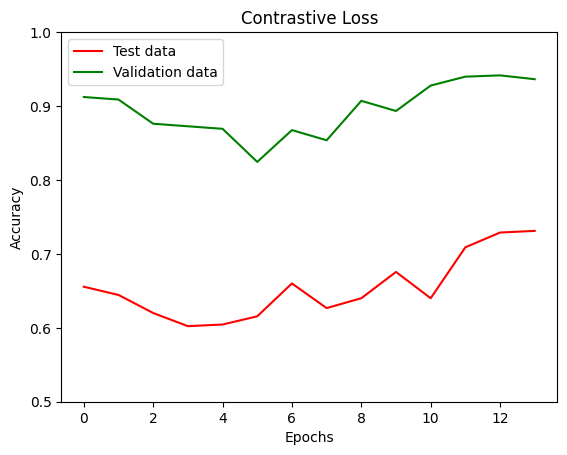

In [13]:
import matplotlib.pyplot as plt
test_accs=testaccs
val_accs=valaccs
plt.ylim(0.5,1)
plt.plot(test_accs,label='Test data', color='r')
plt.plot(val_accs,label='Validation data', color='g')
plt.title('Contrastive Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [14]:
#Evaluate cross entropy models
import pickle
from sklearn.metrics import accuracy_score
dataset_splits=[['FeNi3','Ni','Ni3Al','Al'],['Mo3Si','Cr3Si'],['TiC','NbC','TaC'],['Ge','Si'],
                    ['NiAl','Fe','FeAl','Ta','W','Al4CoNi2'],['TiC','NbC'],['NbC','TaC'],
                    ['NiAl','Fe','FeAl','Al4CoNi2'],['W','Ta']]
phaselist=[phase for phaselist in dataset_splits for phase in phaselist]
phaselist.append('Al4Ni3')
phaselist=sorted(list(set(phaselist)))
phaselist=['Ni','FeNi3','Ni3Al']
with open('/home/ayz0064/crossentropy_preds_test.pkl', 'rb') as file:
    test_data = pickle.load(file)
with open('/home/ayz0064/crossentropy_preds_val.pkl', 'rb') as file:
    val_data = pickle.load(file)
val_acclist=[]
for epoch in val_data.keys():
    preds=[]
    labels=[]
    for img in val_data[epoch]:
        imgname=img.split('/')[-1]
        if 'FeAl' in imgname:
            comp='FeAl'
        else:
            comp=imgname.replace('originalsize_','').split('_')[0].split(' ')[0]
        if comp not in ['Ni','FeNi3','Ni3Al']:
            continue
        preds.append(phaselist.index(val_data[epoch][img]))
        labels.append(phaselist.index(comp))
    acc=accuracy_score(labels,preds)
    val_acclist.append(acc)
epochs=val_acclist.index(max(val_acclist))

test_acclist=[]
for epoch in test_data.keys():
    preds=[]
    labels=[]
    for img in test_data[epoch]:
        imgname=img.split('/')[-1]
        if 'FeAl' in imgname:
            comp='FeAl'
        else:
            comp=imgname.replace('originalsize_','').split('_')[0].split(' ')[0]
        if comp not in ['Ni','FeNi3','Ni3Al']:
            continue
        preds.append(phaselist.index(test_data[epoch][img]))
        
        labels.append(phaselist.index(comp))
    acc=accuracy_score(labels,preds)
    test_acclist.append(acc)

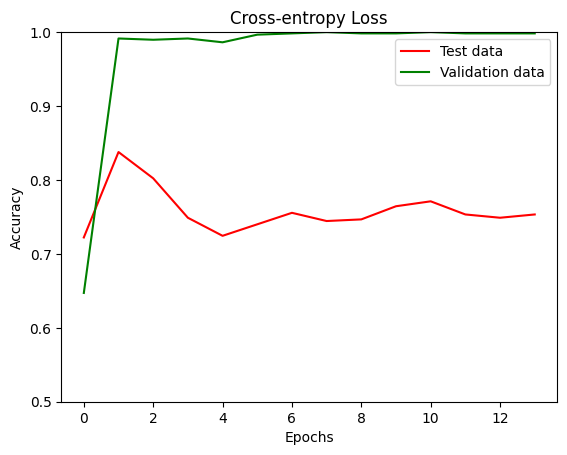

In [15]:
import matplotlib.pyplot as plt
plt.ylim(0,1)
plt.plot(test_acclist,label='Test data', color='r')
plt.plot(val_acclist,label='Validation data',color='g')
plt.title('Cross-entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.legend()

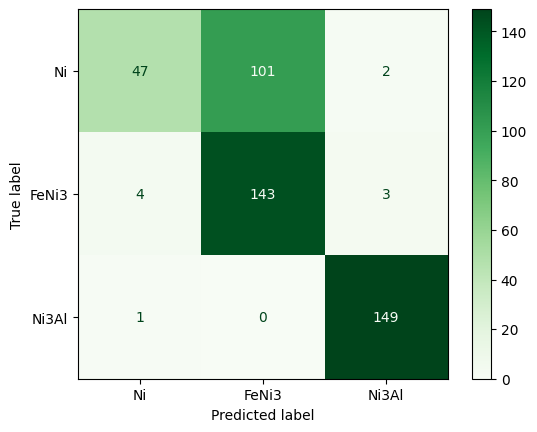

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(labels,preds)
display=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Ni','FeNi3','Ni3Al'])
display.plot(cmap='Greens')
plt.show()